In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, detrend, filtfilt,iirnotch
from scipy.fft import fft, fftfreq


Reading Data RF (RAW EMG)

In [ ]:
# Load Emg file
file_path = r"EMG_right_RF.csv" 

try:
    raw_emg = np.loadtxt(file_path, delimiter=',')
    print("Data loaded successfully:")
    print(raw_emg)
except Exception as e:
    print(f"An error occurred: {e}")


Data loaded successfully:
[-0.016181 -0.016505 -0.017154 ... -0.015208 -0.016181 -0.016505]


Amplify Raw Emg

In [ ]:
def amplify (emg):
  amplification_factor = 10350.0  # Select you own EMG MUSCLE KIT AMPLIFIER GAIN
  amplified_emg_data = emg * amplification_factor
  return amplified_emg_data

raw_emg = amplify(raw_emg) 
print (raw_emg)
print(len(raw_emg))

[-110.4345  -127.21185 -258.0669  ... -103.71735 -164.11995 -164.11995]
171000


Time stamps of Raw EMG

In [ ]:
fs = 1000  
N = len(raw_emg)  
T = 1 / fs 

T_total = N / fs  # in seconds
print(f"Total time covered by the dataset: {T_total} seconds")
time_stamps = np.arange(0, T_total, T)
print(time_stamps)

Total time covered by the dataset: 171.0 seconds
[0.00000e+00 1.00000e-03 2.00000e-03 ... 1.70997e+02 1.70998e+02
 1.70999e+02]


Time Domain Raw EMG

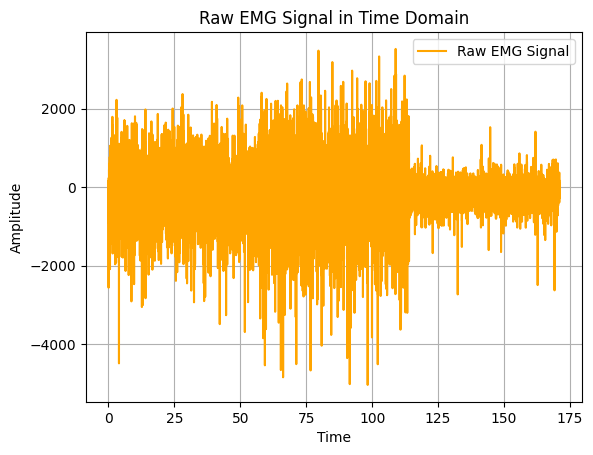

In [ ]:
def plot_time_domain(time,raw_emg):
    # Function to plot EMG signal in time domain
    plt.figure() 
    plt.plot(time, raw_emg, color='orange', label= 'Raw EMG Signal') 
    plt.title('Raw EMG Signal in Time Domain') 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.legend()
    plt.show() 

plot_time_domain( time_stamps, raw_emg) 

Power Spevtrum

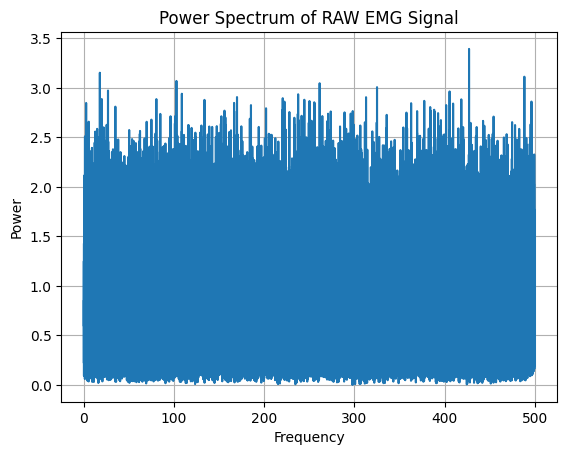

In [ ]:
emg_signal = detrend(raw_emg) 

time_interval = np.diff(time_stamps) 
avg_interval = np.mean(time_interval) 
N= len(raw_emg) 
fs = 1/avg_interval
yf=fft(emg_signal)
xf=fftfreq(N, 1/fs)[1:N//2]

power_spectrum = 2.0/N * np.abs(yf[1:N//2])
plt.plot(xf, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power Spectrum of RAW EMG Signal')
plt.grid(True)
plt.show()

Filteration

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def apply_notch_filter(data, fs, notch_freq=50.0, quality_factor=30.0):
    b_notch, a_notch = iirnotch(notch_freq / (fs / 2), quality_factor)
    notch_filtered_data = filtfilt(b_notch, a_notch, data)
    return notch_filtered_data

def filter_emg(emg_data, time_stamps):
    time_interval = np.mean(np.diff(time_stamps))
    fs = 1 / time_interval

    lowcut = 20  # Low cutoff frequency in Hz
    highcut = 490  # High cutoff frequency in Hz
    
    detrended_emg = emg_data - np.mean(emg_data)  # Detrend the EMG data
    band_passed_emg = apply_bandpass_filter(detrended_emg, lowcut, highcut, fs)
    notch_filtered_emg = apply_notch_filter(band_passed_emg, fs)
    return notch_filtered_emg

# Example usage
fil_emg = filter_emg(raw_emg, time_stamps)

print("Filtered EMG data:", fil_emg)
print("Number of samples:", len(fil_emg))


Filtered EMG data: [  37.63303704   -4.54199376 -102.16956282 ...   61.22329829   20.30700062
    5.53695506]
Number of samples: 171000


Power spectrum

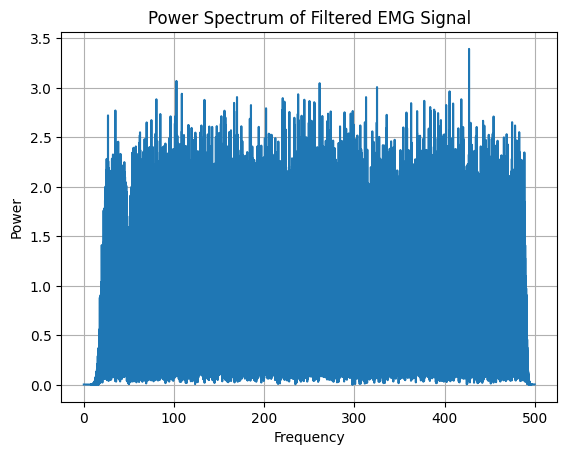

In [ ]:

N= len(raw_emg) 
fs = 1/avg_interval
yf=fft(fil_emg)
xf=fftfreq(N, 1/fs)[1:N//2]

power_spectrum = 2.0/N * np.abs(yf[1:N//2])
plt.plot(xf, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power Spectrum of Filtered EMG Signal')
plt.grid(True)
plt.show()

Rectification

In [ ]:
def rectify(fil_emg):
 # Function to rectify EMG data
    fil_emg = np.abs (fil_emg) 
    return fil_emg 

rectified_emg = rectify(fil_emg) 
print(rectified_emg)
print(len(rectified_emg))

[ 37.63303704   4.54199376 102.16956282 ...  61.22329829  20.30700062
   5.53695506]
171000


Normalization

In [ ]:
def minmax_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

nor_emg = minmax_normalize(rectified_emg)
print (np.max(nor_emg)) 
print(len(nor_emg))

1.0
171000


Envelop

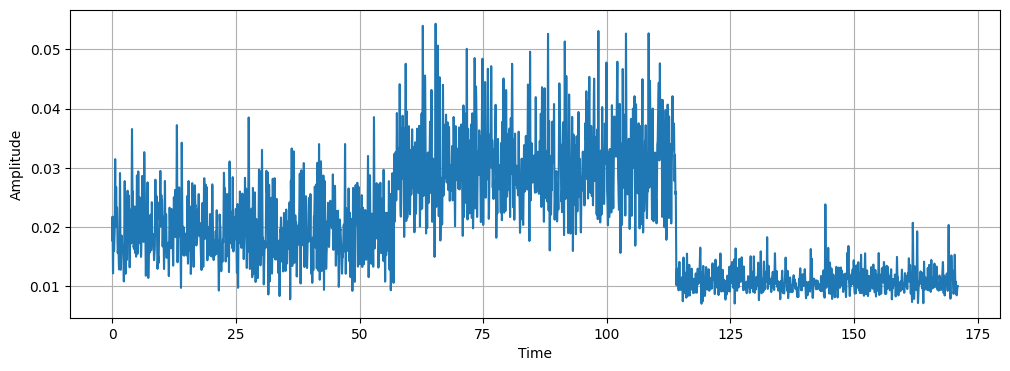

In [ ]:
def extract_emg_envelope(rectified_emg, fs, low_pass_cut=5, filter_order=4):
    b_low, a_low = butter(filter_order, low_pass_cut / (fs / 2), btype='low')  # Butterworth low-pass filter
    envelope_emg = filtfilt(b_low, a_low, rectified_emg)
    return envelope_emg

envelope = extract_emg_envelope(nor_emg, fs=1000)

plt.figure(figsize=(12,4))
plt.plot(time_stamps,envelope)
plt.xlabel('Time')
plt.ylabel('Amplitude') 
plt.grid(True) 
plt.show() 

Plot Processed Time Domain 

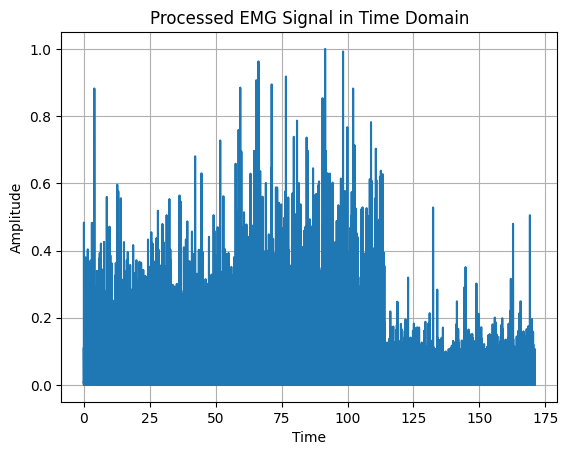

In [ ]:
def plot_time_domain(time,emg,title):
    # Function to plot EMG signal in time domain
    plt.figure() 
    plt.plot(time,emg) 
    plt.title(title) 
    plt.xlabel('Time') 
    plt.ylabel('Amplitude') 
    plt.grid(True) 
    plt.show() 

plot_time_domain(time_stamps, nor_emg, 'Processed EMG Signal in Time Domain') 

Power Spectrum Of Processed EMG

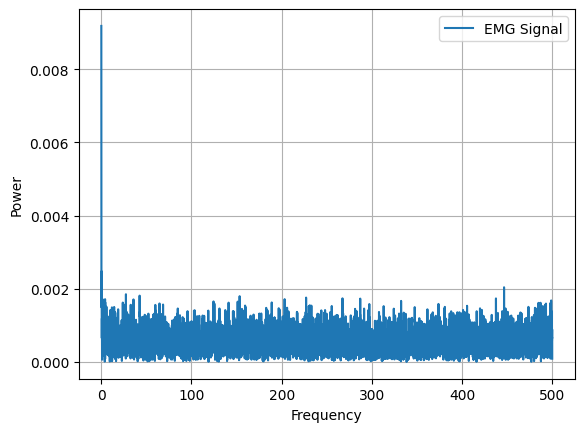

In [ ]:

N= len(nor_emg) 
fs = 1/avg_interval
yf=fft(nor_emg)
xf=fftfreq(N, 1/fs)[1:N//2]

power_spectrum = 2.0/N * np.abs(yf[1:N//2])
plt.plot(xf, power_spectrum, label= 'EMG Signal')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

Storing the pre processed emg

In [ ]:
df=pd.DataFrame({'EMG Data':nor_emg})
csv_file_path = r"emg_norm.csv"
df.to_csv (csv_file_path,index=False)